In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Preprocess import Preprocessor
%matplotlib inline

In [2]:
column_names = ["Time","VehicleSpeed","ShiftNumber","EngineLoad","TotalAcc","EngineRPM","Pitch","LatAcc","PassCount","CarLoad","AirCondStatus","WindowOpen","RadioVolume","RainIntensity","Visibility","DriverWellbeing","DriverRush"]

In [3]:
df = pd.DataFrame(columns=column_names)
for i in range(1,38):
    tempdf = pd.read_csv("Processed Data/fileID"+str(i)+"_ProcessedTripData.csv",names=column_names)
    df = df.append(tempdf)

In [4]:
preprocessor = Preprocessor(df)

In [5]:
reframed = preprocessor.Run()

In [20]:
values = reframed.values
training_samples = round(len(reframed)*1/100)
validation_samples = training_samples + round(len(reframed)*0.5/100)
train = values[:training_samples, :]
validate = values[training_samples:validation_samples, :]
test = values[validation_samples:, :]

In [21]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)',
       'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)',
       'var21(t-1)', 'var16(t)', 'var17(t)', 'var18(t)', 'var19(t)',
       'var20(t)', 'var21(t)'],
      dtype='object')

In [22]:

# split into input and outputs
train_X, train_y = train[:, :-6], train[:, -6:]
validate_X, validate_y = validate[:, :-6], validate[:, -6:]
test_X, test_y = test[:, :-6], test[:, -6:]

In [23]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validate_X = validate_X.reshape((validate_X.shape[0], 1, validate_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, validate_X.shape, validate_y.shape,test_X.shape, test_y.shape)

(76470, 1, 21) (76470, 6) (38235, 1, 21) (38235, 6) (7532285, 1, 21) (7532285, 6)


In [24]:
import keras

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

In [26]:
# design network
model = Sequential()

In [27]:
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# fit network
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph1', histogram_freq=0,  
          write_graph=True)
history = model.fit(train_X, train_y, epochs=10, batch_size=256, validation_data=(validate_X, validate_y), shuffle=False, callbacks =[tbCallBack])
# plot history

Train on 76470 samples, validate on 38235 samples
Epoch 1/10
76470/76470 [==============================] - 2s - loss: 1.4779 - acc: 0.4731 - val_loss: 0.9788 - val_acc: 0.6160
Epoch 2/10
76470/76470 [==============================] - 1s - loss: 0.7216 - acc: 0.7784 - val_loss: 0.2792 - val_acc: 0.9980
Epoch 3/10
76470/76470 [==============================] - 1s - loss: 0.2051 - acc: 0.9757 - val_loss: 0.0922 - val_acc: 0.9980
Epoch 4/10
76470/76470 [==============================] - 1s - loss: 0.0939 - acc: 0.9859 - val_loss: 0.0525 - val_acc: 0.9980
Epoch 5/10
76470/76470 [==============================] - 1s - loss: 0.0579 - acc: 0.9883 - val_loss: 0.0376 - val_acc: 0.9980
Epoch 6/10
76470/76470 [==============================] - 1s - loss: 0.0397 - acc: 0.9984 - val_loss: 0.0299 - val_acc: 0.9980
Epoch 7/10
76470/76470 [==============================] - 1s - loss: 0.0294 - acc: 0.9984 - val_loss: 0.0252 - val_acc: 0.9980
Epoch 8/10
76470/76470 [==============================] - 1s 

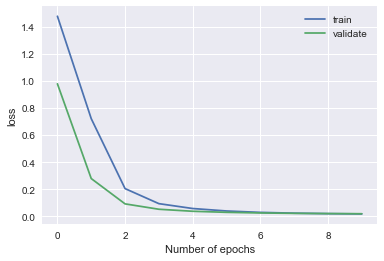

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.xlabel('Number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [29]:
yhat = model.predict(test_X,verbose=1)

7531680/7532285 [============================>.] - ETA: 0s

In [30]:
test_y

array([[ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [31]:
for values in yhat:
    max_index = np.argmax(values)
    values[max_index] = 1
    for index in range(0,6):
        if max_index != index:
            values[index] = 0    

In [32]:
yhat

array([[ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [33]:
from sklearn.metrics import precision_score, f1_score
print(precision_score(test_y,yhat,average='micro'))

0.998606133464


In [34]:
tps = np.zeros(6)
fps = np.zeros(6)
samples = np.zeros(6)
for pred,true in zip(yhat,test_y):
    for idx in range(0,6):
        if pred[idx] == 1 and true[idx] == 1:
            tps[idx] = tps[idx] + 1
        elif (pred[idx] == 1 and true[idx] == 0):
            fps[idx] = fps[idx] + 1
        if true[idx] == 1:
            samples[idx] = samples[idx] + 1
print(tps,fps,samples)

[ 3481896.   290294.   933947.  1075168.   833001.   907480.] [ 5249.  1384.  1618.  1190.   737.   321.] [ 3487146.   291678.   935565.  1076357.   833738.   907801.]


In [35]:
#Microaveraged precision
np.sum(tps)/(np.sum(tps)+np.sum(fps))

0.99860613346414795

In [36]:
#individual precision
tps/(tps+fps)

array([ 0.99849476,  0.99525504,  0.99827056,  0.99889442,  0.99911603,
        0.9996464 ])